# Clustering (taking into account the pre-calculated Clusters)

## 1. Import Libraries

In [114]:
# Import Libraries

import pandas as pd
import numpy as np

# não sei porque é que os comandos abaixo são necessários, mas eliminam mensagens de erro do geopandas
import os
os.environ['USE_PYGEOS'] = '0'
import geopandas

import matplotlib.pyplot as plt
import contextily as cx

from geopandas import GeoDataFrame
from shapely.geometry import Point
import statsmodels.api as sm

from pysal.lib import weights
from pysal.explore import esda
from pysal.viz import splot
from splot.esda import plot_moran_bv
import mapclassify as mc
from pysal.model import spreg
import spopt

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import pairwise as skm
from sklearn.metrics import silhouette_score, silhouette_samples
from yellowbrick.cluster import SilhouetteVisualizer, KElbowVisualizer
from sklearn.metrics import davies_bouldin_score

import scipy.cluster.hierarchy as sch

from spopt.region import MaxPHeuristic as MaxP
from libpysal.weights import Queen

import scipy.sparse as sp

import plotly.io as pio
pio.renderers.default='notebook'

In [115]:
# path definition for each user - please edit to add new users
path_pb = "C:/Users/pauloricardolb/OneDrive - Universidade de Aveiro/TRABALHO_PROJETOS/AP01_ONGOING/POAT/SHARED_Andre"
path_al = "/Users/andresilvalima/Library/CloudStorage/OneDrive-UniversidadedeAveiro/SHARED_Andre"

In [116]:
# path definition
path = path_al

## 2. Loading Data, Transforming Variables

In [117]:
# read data
bgri_cluster = pd.read_pickle(path + "/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/piclo_bgri.piclo")

In [118]:
bgri_cluster.head()

,GEO_COD,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,...,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID,FREGUESIA,LUGAR,LUGAR_NOME,area,geometry,Cluster_new
0,1050100101,6,0,0,0,0,6,0,2,4,...,10,48,25,46,1050100101,014757,Aveiro,0.017079,"POLYGON ((-43546.037 106682.578, -43536.309 10...",30
1,1050100102,2,0,0,0,0,2,0,1,1,...,14,37,19,29,1050100102,014757,Aveiro,0.035924,"POLYGON ((-43419.983 106675.222, -43347.430 10...",124
2,1050100103,14,2,1,1,0,12,0,6,8,...,11,43,14,36,1050100103,014757,Aveiro,0.016797,"POLYGON ((-43407.910 106578.158, -43407.908 10...",124
3,1050100104,4,0,0,0,0,4,0,0,4,...,5,36,12,30,1050100104,014757,Aveiro,0.005773,"POLYGON ((-43485.920 106470.923, -43518.029 10...",3
4,1050100105,13,11,7,4,0,2,0,13,0,...,10,71,21,60,1050100105,014757,Aveiro,0.036753,"POLYGON ((-43057.880 106525.743, -43057.411 10...",58


In [119]:
# read data
clusters = pd.read_pickle(path + "/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/piclo_clusters.piclo")

In [120]:
clusters.head()

,Cluster_new,geometry,area
0,1,"POLYGON ((-43858.268 105485.133, -43926.607 10...",0.036101
1,2,"POLYGON ((-41894.818 101023.152, -41985.704 10...",0.023841
2,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286
3,4,"POLYGON ((-42925.331 103598.712, -42932.138 10...",0.142291
4,5,"POLYGON ((-42665.937 104985.157, -42696.042 10...",0.141979


In [121]:
clusters.shape

(128, 3)

In [122]:
bgri_cluster.head()

,GEO_COD,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,...,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID,FREGUESIA,LUGAR,LUGAR_NOME,area,geometry,Cluster_new
0,1050100101,6,0,0,0,0,6,0,2,4,...,10,48,25,46,1050100101,014757,Aveiro,0.017079,"POLYGON ((-43546.037 106682.578, -43536.309 10...",30
1,1050100102,2,0,0,0,0,2,0,1,1,...,14,37,19,29,1050100102,014757,Aveiro,0.035924,"POLYGON ((-43419.983 106675.222, -43347.430 10...",124
2,1050100103,14,2,1,1,0,12,0,6,8,...,11,43,14,36,1050100103,014757,Aveiro,0.016797,"POLYGON ((-43407.910 106578.158, -43407.908 10...",124
3,1050100104,4,0,0,0,0,4,0,0,4,...,5,36,12,30,1050100104,014757,Aveiro,0.005773,"POLYGON ((-43485.920 106470.923, -43518.029 10...",3
4,1050100105,13,11,7,4,0,2,0,13,0,...,10,71,21,60,1050100105,014757,Aveiro,0.036753,"POLYGON ((-43057.880 106525.743, -43057.411 10...",58


In [123]:
# drop unnecessary columns
bgri_cluster.drop(columns=['area','geometry','GEO_COD','FREGUESIA','LUGAR','LUGAR_NOME'], inplace=True)

In [124]:
bgri_cluster.shape

# bgri_cluster contem:
# 1. 122 indicadores socioeconómicos (relacionados com habitação)
# 2. geo_code é o código da subseccao
# 3. clusters coding
# 4. area
# 5. polígono.

(1827, 123)

In [125]:
# group by cluster and sum values, getting socioeconomic indicators for each cluster (from the subsection information)
bgri_cluster = bgri_cluster.groupby(["Cluster_new"]).sum().reset_index(level='Cluster_new')

In [126]:
bgri_cluster.head()

,Cluster_new,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,...,N_IND_RESID_DESEMP_PROC_1EMPRG,N_IND_RESID_DESEMP_PROC_EMPRG,N_IND_RESID_EMPREGADOS,N_IND_RESID_PENS_REFORM,N_IND_RESID_SEM_ACT_ECON,N_IND_RESID_EMPREG_SECT_PRIM,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID
0,1,78,72,51,14,7,6,0,75,3,...,2,2,112,52,72,0,24,88,35,75
1,2,742,724,393,180,151,15,3,724,12,...,9,80,866,332,647,16,338,512,342,642
2,3,54,19,9,0,10,35,0,37,17,...,9,32,247,160,256,1,41,205,105,194
3,4,1230,1183,657,323,203,43,4,1167,50,...,23,116,1506,582,1088,22,498,986,707,1140
4,5,551,499,258,107,134,43,9,530,15,...,14,74,817,364,592,9,212,596,307,637


In [127]:
bgri_cluster.shape
# Ok

(128, 123)

In [128]:
# rotinas utilizadas para verificar a presença de NaNs - linhas dropadas


# lista de pontos (X,Y) com NaNs depois de o standardscaler()


# [(24, 36), (24, 37), (24, 38), (28, 34), (28, 35), (44, 1), (44, 2), (44, 3), (44, 4), (44, 5), 
#  (44, 6), (44, 7), (44, 8), (44, 9), (44, 10), (44, 11), (44, 12), (44, 13), (44, 14), (44, 15), 
#  (44, 16), (44, 17), (44, 18), (44, 19), (44, 20), (44, 21), (44, 22), (44, 23), (44, 24), (44, 25), 
#  (44, 26), (44, 27), (44, 28), (44, 29), (44, 30), (44, 31), (44, 32), (44, 33), (44, 34), (44, 35), 
#  (44, 36), (44, 37), (44, 38), (44, 39), (44, 40), (44, 41), (44, 42), (44, 43), (44, 44), (44, 45), 
#  (44, 46), (44, 47), (44, 48), (44, 49), (44, 50), (44, 51), (44, 52), (44, 53), (44, 54), (44, 55), 
#  (44, 56), (44, 57), (44, 58), (44, 59), (44, 60), (44, 61), (44, 62), (44, 63), (44, 64), (44, 65), 
#  (44, 66), (44, 67), (44, 68), (44, 69), (44, 70), (44, 71), (44, 72), (44, 73), (44, 74), (44, 75), 
#  (44, 76), (44, 77), (44, 78), (44, 79), (44, 80), (44, 81), (107, 36), (107, 37), (107, 38), (110, 1), 
#  (110, 2), (110, 3), (110, 4), (110, 5), (110, 6), (110, 7), (110, 8), (110, 9), (110, 10), (110, 11), 
#  (110, 12), (110, 13), (110, 14), (110, 15), (110, 16), (110, 17), (110, 18), (110, 19), (110, 20), 
#  (110, 21), (110, 22), (110, 23), (110, 24), (110, 25), (110, 26), (110, 27), (110, 28), (110, 29),
#  (110, 30), (110, 31), (110, 32), (110, 33), (110, 34), (110, 35), (110, 36), (110, 37), (110, 38), 
#  (110, 39), (110, 40), (110, 41), (110, 42), (110, 43), (110, 44), (110, 45), (110, 46), (110, 47), 
#  (110, 48), (110, 49), (110, 50), (110, 51), (110, 52), (110, 53), (110, 54), (110, 55), (110, 56), 
#  (110, 57), (110, 58), (110, 59), (110, 60), (110, 61), (110, 62), (110, 63), (110, 64), (110, 65), 
#  (110, 66), (110, 67), (110, 68), (110, 69), (110, 70), (110, 71), (110, 72), (110, 73), (110, 74), 
#  (110, 75), (110, 76), (110, 77), (110, 78), (110, 79), (110, 80), (110, 81)]



In [129]:
# drop rows with NaNs
bgri_cluster.drop([24, 28, 44, 107, 110], axis=0, inplace=True)

In [130]:
# filter clusters file, based on the bgri_cluster file (clusters existing in bgri_cluster)
clusters = clusters.loc[clusters['Cluster_new'].isin(bgri_cluster['Cluster_new'])]

In [131]:
clusters.shape

(123, 3)

In [132]:
bgri_cluster.head()

,Cluster_new,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,...,N_IND_RESID_DESEMP_PROC_1EMPRG,N_IND_RESID_DESEMP_PROC_EMPRG,N_IND_RESID_EMPREGADOS,N_IND_RESID_PENS_REFORM,N_IND_RESID_SEM_ACT_ECON,N_IND_RESID_EMPREG_SECT_PRIM,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID
0,1,78,72,51,14,7,6,0,75,3,...,2,2,112,52,72,0,24,88,35,75
1,2,742,724,393,180,151,15,3,724,12,...,9,80,866,332,647,16,338,512,342,642
2,3,54,19,9,0,10,35,0,37,17,...,9,32,247,160,256,1,41,205,105,194
3,4,1230,1183,657,323,203,43,4,1167,50,...,23,116,1506,582,1088,22,498,986,707,1140
4,5,551,499,258,107,134,43,9,530,15,...,14,74,817,364,592,9,212,596,307,637


### 2.1 New variables, enhancing the information available in the dataset

In [133]:
# here we prove that N_EDIFICIOS_CLASSICOS_ISOLADOS+N_EDIFICIOS_CLASSICOS_GEMIN+N_EDIFICIOS_CLASSICOS_EMBANDA=N_EDIFICIOS_CLASSICOS_1OU2
bgri_cluster['N_EDIFICIOS_CLASSICOS_1OU2'].sum()==(bgri_cluster['N_EDIFICIOS_CLASSICOS_ISOLADOS']+bgri_cluster['N_EDIFICIOS_CLASSICOS_GEMIN']+bgri_cluster['N_EDIFICIOS_CLASSICOS_EMBANDA']).sum()

True

In [134]:
bgri_cluster.head()

,Cluster_new,N_EDIFICIOS_CLASSICOS,N_EDIFICIOS_CLASSICOS_1OU2,N_EDIFICIOS_CLASSICOS_ISOLADOS,N_EDIFICIOS_CLASSICOS_GEMIN,N_EDIFICIOS_CLASSICOS_EMBANDA,N_EDIFICIOS_CLASSICOS_3OUMAIS,N_EDIFICIOS_CLASSICOS_OUTROS,N_EDIFICIOS_EXCLUSIV_RESID,N_EDIFICIOS_PRINCIPAL_RESID,...,N_IND_RESID_DESEMP_PROC_1EMPRG,N_IND_RESID_DESEMP_PROC_EMPRG,N_IND_RESID_EMPREGADOS,N_IND_RESID_PENS_REFORM,N_IND_RESID_SEM_ACT_ECON,N_IND_RESID_EMPREG_SECT_PRIM,N_IND_RESID_EMPREG_SECT_SEQ,N_IND_RESID_EMPREG_SECT_TERC,N_IND_RESID_ESTUD_MUN_RESID,N_IND_RESID_TRAB_MUN_RESID
0,1,78,72,51,14,7,6,0,75,3,...,2,2,112,52,72,0,24,88,35,75
1,2,742,724,393,180,151,15,3,724,12,...,9,80,866,332,647,16,338,512,342,642
2,3,54,19,9,0,10,35,0,37,17,...,9,32,247,160,256,1,41,205,105,194
3,4,1230,1183,657,323,203,43,4,1167,50,...,23,116,1506,582,1088,22,498,986,707,1140
4,5,551,499,258,107,134,43,9,530,15,...,14,74,817,364,592,9,212,596,307,637


In [135]:
bgri_cluster.shape

(123, 123)

In [136]:
# sabemos que N_EDIFICIOS_CLASSICOS = N_EDIFICIOS_CLASSICOS_ISOLADOS + N_EDIFICIOS_CLASSICOS_GEMIN + N_EDIFICIOS_CLASSICOS_EMBANDA + 
# + N_EDIFICIOS_CLASSICOS_3OUMAIS + N_EDIFICIOS_CLASSICOS_OUTROS

# drop possivel - N_EDIFICIOS_CLASSICOS_OUTROS (para não dar 100%)

bgri_cluster['PER_EDIFICIOS_CLASSICOS_ISOLADOS']=bgri_cluster['N_EDIFICIOS_CLASSICOS_ISOLADOS']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_GEMIN']=bgri_cluster['N_EDIFICIOS_CLASSICOS_GEMIN']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_EMBANDA']=bgri_cluster['N_EDIFICIOS_CLASSICOS_EMBANDA']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_1OU2']=bgri_cluster['N_EDIFICIOS_CLASSICOS_1OU2']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_3OUMAIS']=bgri_cluster['N_EDIFICIOS_CLASSICOS_3OUMAIS']/bgri_cluster['N_EDIFICIOS_CLASSICOS']
bgri_cluster['PER_EDIFICIOS_CLASSICOS_OUTROS']=bgri_cluster['N_EDIFICIOS_CLASSICOS_OUTROS']/bgri_cluster['N_EDIFICIOS_CLASSICOS']

bgri_cluster.drop(['N_EDIFICIOS_CLASSICOS','N_EDIFICIOS_CLASSICOS_1OU2', 'N_EDIFICIOS_CLASSICOS_ISOLADOS','N_EDIFICIOS_CLASSICOS_GEMIN',
                   'N_EDIFICIOS_CLASSICOS_EMBANDA','N_EDIFICIOS_CLASSICOS_3OUMAIS','N_EDIFICIOS_CLASSICOS_OUTROS'], axis=1, inplace=True)

In [137]:
# sabemos que N_EDIFICIOS_EXCLUSIV_RESID + N_EDIFICIOS_PRINCIPAL_RESID + N_EDIFICIOS_PRINCIP_NAO_RESID =
# = N_EDIFICIOS_1OU2_PISOS + N_EDIFICIOS_3OU4_PISOS + N_EDIFICIOS_5OU_MAIS_PISOS

# drop possivel - PER_EDIFICIOS_5OU_MAIS_PISOS (para não dar 100%)

bgri_cluster['total_temp']=bgri_cluster['N_EDIFICIOS_EXCLUSIV_RESID']+bgri_cluster['N_EDIFICIOS_PRINCIPAL_RESID']+bgri_cluster['N_EDIFICIOS_PRINCIP_NAO_RESID']

bgri_cluster['PER_EDIFICIOS_EXCLUSIV_RESID']=bgri_cluster['N_EDIFICIOS_EXCLUSIV_RESID']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_PRINCIPAL_RESID']=bgri_cluster['N_EDIFICIOS_PRINCIPAL_RESID']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_PRINCIP_NAO_RESID']=bgri_cluster['N_EDIFICIOS_PRINCIP_NAO_RESID']/bgri_cluster['total_temp']

bgri_cluster['PER_EDIFICIOS_1OU2_PISOS']=bgri_cluster['N_EDIFICIOS_1OU2_PISOS']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_3OU4_PISOS']=bgri_cluster['N_EDIFICIOS_3OU4_PISOS']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_5OU_MAIS_PISOS']=bgri_cluster['N_EDIFICIOS_5OU_MAIS_PISOS']/bgri_cluster['total_temp']

bgri_cluster.drop(['total_temp','N_EDIFICIOS_EXCLUSIV_RESID','N_EDIFICIOS_PRINCIPAL_RESID','N_EDIFICIOS_PRINCIP_NAO_RESID',
                   'N_EDIFICIOS_1OU2_PISOS','N_EDIFICIOS_3OU4_PISOS','N_EDIFICIOS_5OU_MAIS_PISOS'], axis=1, inplace=True)

In [138]:
# conversão dos indicadores do ano de construção em percentagens do total de casas

# drop possivel - N_EDIFICIOS_CONSTR_2006A2011 (para não dar 100%)

bgri_cluster['total_temp']=bgri_cluster['N_EDIFICIOS_CONSTR_ANTES_1919']+bgri_cluster['N_EDIFICIOS_CONSTR_1919A1945']+bgri_cluster['N_EDIFICIOS_CONSTR_1946A1960']+bgri_cluster['N_EDIFICIOS_CONSTR_1961A1970']+bgri_cluster['N_EDIFICIOS_CONSTR_1971A1980']+bgri_cluster['N_EDIFICIOS_CONSTR_1981A1990']+bgri_cluster['N_EDIFICIOS_CONSTR_1991A1995']+bgri_cluster['N_EDIFICIOS_CONSTR_1996A2000']+bgri_cluster['N_EDIFICIOS_CONSTR_2001A2005']+bgri_cluster['N_EDIFICIOS_CONSTR_2006A2011']

bgri_cluster['PER_EDIFICIOS_CONSTR_ANTES_1919']=bgri_cluster['N_EDIFICIOS_CONSTR_ANTES_1919']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1919A1945']=bgri_cluster['N_EDIFICIOS_CONSTR_1919A1945']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1946A1960']=bgri_cluster['N_EDIFICIOS_CONSTR_1946A1960']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1961A1970']=bgri_cluster['N_EDIFICIOS_CONSTR_1961A1970']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1971A1980']=bgri_cluster['N_EDIFICIOS_CONSTR_1971A1980']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1981A1990']=bgri_cluster['N_EDIFICIOS_CONSTR_1981A1990']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1991A1995']=bgri_cluster['N_EDIFICIOS_CONSTR_1991A1995']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_1996A2000']=bgri_cluster['N_EDIFICIOS_CONSTR_1996A2000']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_2001A2005']=bgri_cluster['N_EDIFICIOS_CONSTR_2001A2005']/bgri_cluster['total_temp']
bgri_cluster['PER_EDIFICIOS_CONSTR_2006A2011']=bgri_cluster['N_EDIFICIOS_CONSTR_2006A2011']/bgri_cluster['total_temp']

bgri_cluster.drop(['total_temp','N_EDIFICIOS_CONSTR_ANTES_1919','N_EDIFICIOS_CONSTR_1919A1945','N_EDIFICIOS_CONSTR_1946A1960','N_EDIFICIOS_CONSTR_1961A1970','N_EDIFICIOS_CONSTR_1971A1980','N_EDIFICIOS_CONSTR_1981A1990','N_EDIFICIOS_CONSTR_1991A1995','N_EDIFICIOS_CONSTR_1996A2000','N_EDIFICIOS_CONSTR_2001A2005','N_EDIFICIOS_CONSTR_2006A2011'], axis=1, inplace=True)

In [139]:
# vamos agora droppar variáveis que decidimos não usar, por acreditarmos que não "informam" o modelo

bgri_cluster.drop(['N_EDIFICIOS_ESTRUT_BETAO','N_EDIFICIOS_ESTRUT_COM_PLACA','N_EDIFICIOS_ESTRUT_SEM_PLACA','N_EDIFICIOS_ESTRUT_ADOBE_PEDRA','N_EDIFICIOS_ESTRUT_OUTRA'], axis=1, inplace=True)

In [140]:
# "Cluster" de Variáveis em análise: N_ALOJAMENTOS, N_ALOJAMENTOS_FAM_CLASSICOS, N_ALOJAMENTOS_FAM_N_CLASSICOS, N_ALOJAMENTOS_COLECTIVOS, N_CLASSICOS_RES_HABITUAL, N_ALOJAMENTOS_RES_HABITUAL, N_ALOJAMENTOS_VAGOS
# Após análise (à parte), definiu-se que toda a informação destas variáveis está contida nos seguintes percentuais:

bgri_cluster['PER_ALOJAMENTOS_FAM_CLASSICOS']=bgri_cluster['N_ALOJAMENTOS_FAM_CLASSICOS']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_FAM_N_CLASSICOS']=bgri_cluster['N_ALOJAMENTOS_FAM_N_CLASSICOS']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_COLECTIVOS']=bgri_cluster['N_ALOJAMENTOS_COLECTIVOS']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_CLASSICOS_RES_HABITUAL']=bgri_cluster['N_CLASSICOS_RES_HABITUAL']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_RES_HABITUAL']=bgri_cluster['N_ALOJAMENTOS_RES_HABITUAL']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_VAGOS']=bgri_cluster['N_ALOJAMENTOS_VAGOS']/bgri_cluster['N_ALOJAMENTOS']
bgri_cluster['PER_ALOJAMENTOS_FAMILIARES']=bgri_cluster['N_ALOJAMENTOS_FAMILIARES']/bgri_cluster['N_ALOJAMENTOS']

bgri_cluster.drop(['N_ALOJAMENTOS', 'N_ALOJAMENTOS_FAM_CLASSICOS', 'N_ALOJAMENTOS_FAM_N_CLASSICOS', 'N_ALOJAMENTOS_COLECTIVOS', 'N_CLASSICOS_RES_HABITUAL', 'N_ALOJAMENTOS_RES_HABITUAL', 'N_ALOJAMENTOS_VAGOS','N_ALOJAMENTOS_FAMILIARES'], axis=1, inplace=True)

In [141]:
# vamos droppar as seguintes variáveis 'N_RES_HABITUAL_COM_AGUA','N_RES_HABITUAL_COM_RETRETE','N_RES_HABITUAL_COM_ESGOTOS','N_RES_HABITUAL_COM_BANHO'

bgri_cluster.drop(['N_RES_HABITUAL_COM_AGUA','N_RES_HABITUAL_COM_RETRETE','N_RES_HABITUAL_COM_ESGOTOS','N_RES_HABITUAL_COM_BANHO'], axis=1, inplace=True)

In [142]:
# Próximo Cluster de 'N_RES_HABITUAL_AREA_50', 'N_RES_HABITUAL_AREA_50_100', 'N_RES_HABITUAL_AREA_100_200', 'N_RES_HABITUAL_AREA_200'

bgri_cluster['temp_total']=bgri_cluster['N_RES_HABITUAL_AREA_50']+bgri_cluster['N_RES_HABITUAL_AREA_50_100']+bgri_cluster['N_RES_HABITUAL_AREA_100_200']+bgri_cluster['N_RES_HABITUAL_AREA_200']

bgri_cluster['PER_RES_HABITUAL_AREA_50']=bgri_cluster['N_RES_HABITUAL_AREA_50']/bgri_cluster['temp_total']
bgri_cluster['PER_RES_HABITUAL_AREA_50_100']=bgri_cluster['N_RES_HABITUAL_AREA_50_100']/bgri_cluster['temp_total']
bgri_cluster['PER_RES_HABITUAL_AREA_100_200']=bgri_cluster['N_RES_HABITUAL_AREA_100_200']/bgri_cluster['temp_total']
bgri_cluster['PER_RES_HABITUAL_AREA_200']=bgri_cluster['N_RES_HABITUAL_AREA_200']/bgri_cluster['temp_total']

bgri_cluster.drop(['temp_total','N_RES_HABITUAL_AREA_50', 'N_RES_HABITUAL_AREA_50_100', 'N_RES_HABITUAL_AREA_100_200', 'N_RES_HABITUAL_AREA_200'], axis=1, inplace=True)

In [143]:
# Próximo Cluster de 'N_RES_HABITUAL_1_2_DIV','N_RES_HABITUAL_3_4_DIV','N_RES_HABITUAL_ESTAC_1','N_RES_HABITUAL_ESTAC_2','N_RES_HABITUAL_ESTAC_3','N_RES_HABITUAL_PROP_OCUP','N_RES_HABITUAL_ARREND'
# Não fui capaz de encontrar relação entre variáveis (os totais não batem certo), pelo que serão criados 3 subtotais e as variáveis serão percentagens desses subtotais

bgri_cluster['temp_total1']=bgri_cluster['N_RES_HABITUAL_1_2_DIV']+bgri_cluster['N_RES_HABITUAL_3_4_DIV']
bgri_cluster['temp_total2']=bgri_cluster['N_RES_HABITUAL_ESTAC_1']+bgri_cluster['N_RES_HABITUAL_ESTAC_2']+bgri_cluster['N_RES_HABITUAL_ESTAC_3']
bgri_cluster['temp_total3']=bgri_cluster['N_RES_HABITUAL_PROP_OCUP']+bgri_cluster['N_RES_HABITUAL_ARREND']

bgri_cluster['PER_RES_HABITUAL_1_2_DIV']=bgri_cluster['N_RES_HABITUAL_1_2_DIV']/bgri_cluster['temp_total1']
bgri_cluster['PER_RES_HABITUAL_3_4_DIV']=bgri_cluster['N_RES_HABITUAL_3_4_DIV']/bgri_cluster['temp_total1']
bgri_cluster['PER_RES_HABITUAL_ESTAC_1']=bgri_cluster['N_RES_HABITUAL_ESTAC_1']/bgri_cluster['temp_total2']
bgri_cluster['PER_RES_HABITUAL_ESTAC_2']=bgri_cluster['N_RES_HABITUAL_ESTAC_2']/bgri_cluster['temp_total2']
bgri_cluster['PER_RES_HABITUAL_ESTAC_3']=bgri_cluster['N_RES_HABITUAL_ESTAC_3']/bgri_cluster['temp_total2']
bgri_cluster['PER_RES_HABITUAL_PROP_OCUP']=bgri_cluster['N_RES_HABITUAL_PROP_OCUP']/bgri_cluster['temp_total3']
bgri_cluster['PER_RES_HABITUAL_ARREND']=bgri_cluster['N_RES_HABITUAL_ARREND']/bgri_cluster['temp_total3']


bgri_cluster.drop(['temp_total1','temp_total2','temp_total3','N_RES_HABITUAL_1_2_DIV','N_RES_HABITUAL_3_4_DIV','N_RES_HABITUAL_ESTAC_1','N_RES_HABITUAL_ESTAC_2','N_RES_HABITUAL_ESTAC_3','N_RES_HABITUAL_PROP_OCUP','N_RES_HABITUAL_ARREND'], axis=1, inplace=True)

In [144]:
# Próximo Cluster de 'N_FAMILIAS_CLASSICAS','N_FAMILIAS_INSTITUCIONAIS','N_FAMILIAS_CLASSICAS_1OU2_PESS','N_FAMILIAS_CLASSICAS_3OU4_PESS','N_FAMILIAS_CLASSICAS_NPES65',
                    #'N_FAMILIAS_CLASSICAS_NPES14','N_FAMILIAS_CLASSIC_SEM_DESEMP','N_FAMILIAS_CLASSIC_1DESEMPREG','N_FAMILIAS_CLASS_2MAIS_DESEMP'

# Não fui capaz de encontrar relação entre todas as variáveis (os totais não batem todos certo), pelo que serão as variáveis serão percentagens do N_FAMILIAS_CLASSICAS

bgri_cluster['PER_FAMILIAS_INSTITUCIONAIS']=bgri_cluster['N_FAMILIAS_INSTITUCIONAIS']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSICAS_1OU2_PESS']=bgri_cluster['N_FAMILIAS_CLASSICAS_1OU2_PESS']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSICAS_3OU4_PESS']=bgri_cluster['N_FAMILIAS_CLASSICAS_3OU4_PESS']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSICAS_NPES65']=bgri_cluster['N_FAMILIAS_CLASSICAS_NPES65']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSICAS_NPES14']=bgri_cluster['N_FAMILIAS_CLASSICAS_NPES14']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSIC_SEM_DESEMP']=bgri_cluster['N_FAMILIAS_CLASSIC_SEM_DESEMP']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASSIC_1DESEMPREG']=bgri_cluster['N_FAMILIAS_CLASSIC_1DESEMPREG']/bgri_cluster['N_FAMILIAS_CLASSICAS']
bgri_cluster['PER_FAMILIAS_CLASS_2MAIS_DESEMP']=bgri_cluster['N_FAMILIAS_CLASS_2MAIS_DESEMP']/bgri_cluster['N_FAMILIAS_CLASSICAS']

bgri_cluster.drop(['N_FAMILIAS_CLASSICAS','N_FAMILIAS_INSTITUCIONAIS','N_FAMILIAS_CLASSICAS_1OU2_PESS','N_FAMILIAS_CLASSICAS_3OU4_PESS','N_FAMILIAS_CLASSICAS_NPES65','N_FAMILIAS_CLASSICAS_NPES14','N_FAMILIAS_CLASSIC_SEM_DESEMP','N_FAMILIAS_CLASSIC_1DESEMPREG','N_FAMILIAS_CLASS_2MAIS_DESEMP'], axis=1, inplace=True)

In [145]:
# Próximo Cluster de 'N_NUCLEOS_FAMILIARES','N_NUCLEOS_1FILH_NAO_CASADO','N_NUCLEOS_2FILH_NAO_CASADO','N_NUCLEOS_FILH_INF_6ANOS','N_NUCLEOS_FILH_INF_15ANOS','N_NUCLEOS_FILH_MAIS_15ANOS'

# Não fui capaz de encontrar relação entre todas as variáveis (os totais não batem todos certo), pelo que serão as variáveis serão percentagens do N_NUCLEOS_FAMILIARES


bgri_cluster['PER_NUCLEOS_1FILH_NAO_CASADO']=bgri_cluster['N_NUCLEOS_1FILH_NAO_CASADO']/bgri_cluster['N_NUCLEOS_FAMILIARES']
bgri_cluster['PER_NUCLEOS_2FILH_NAO_CASADO']=bgri_cluster['N_NUCLEOS_2FILH_NAO_CASADO']/bgri_cluster['N_NUCLEOS_FAMILIARES']
bgri_cluster['PER_NUCLEOS_FILH_INF_6ANOS']=bgri_cluster['N_NUCLEOS_FILH_INF_6ANOS']/bgri_cluster['N_NUCLEOS_FAMILIARES']
bgri_cluster['PER_NUCLEOS_FILH_INF_15ANOS']=bgri_cluster['N_NUCLEOS_FILH_INF_15ANOS']/bgri_cluster['N_NUCLEOS_FAMILIARES']
bgri_cluster['PER_NUCLEOS_FILH_MAIS_15ANOS']=bgri_cluster['N_NUCLEOS_FILH_MAIS_15ANOS']/bgri_cluster['N_NUCLEOS_FAMILIARES']

bgri_cluster.drop(['N_NUCLEOS_FAMILIARES','N_NUCLEOS_1FILH_NAO_CASADO','N_NUCLEOS_2FILH_NAO_CASADO','N_NUCLEOS_FILH_INF_6ANOS','N_NUCLEOS_FILH_INF_15ANOS','N_NUCLEOS_FILH_MAIS_15ANOS'], axis=1, inplace=True)

In [146]:
# Antes de passarmos ao próximo bloco de indicadores a tratar, vamos eliminar todas as variáveis relativas ao sexo dos residentes, mantendo aoenas informação relativa à idade
bgri_cluster.drop(['N_INDIVIDUOS_PRESENT_H','N_INDIVIDUOS_PRESENT_M','N_INDIVIDUOS_RESIDENT_H','N_INDIVIDUOS_RESIDENT_M','N_INDIVIDUOS_RESIDENT_H_0A4',
                   'N_INDIVIDUOS_RESIDENT_H_5A9','N_INDIVIDUOS_RESIDENT_H_10A13','N_INDIVIDUOS_RESIDENT_H_14A19','N_INDIVIDUOS_RESIDENT_H_15A19','N_INDIVIDUOS_RESIDENT_H_20A24',
                   'N_INDIVIDUOS_RESIDENT_H_20A64','N_INDIVIDUOS_RESIDENT_H_25A64','N_INDIVIDUOS_RESIDENT_H_65','N_INDIVIDUOS_RESIDENT_M_0A4','N_INDIVIDUOS_RESIDENT_M_5A9',
                   'N_INDIVIDUOS_RESIDENT_M_10A13','N_INDIVIDUOS_RESIDENT_M_14A19','N_INDIVIDUOS_RESIDENT_M_15A19','N_INDIVIDUOS_RESIDENT_M_20A24','N_INDIVIDUOS_RESIDENT_M_20A64',
                   'N_INDIVIDUOS_RESIDENT_M_25A64','N_INDIVIDUOS_RESIDENT_M_65'], axis=1, inplace=True)


In [147]:
# Próximo Cluster de 'N_INDIVIDUOS_PRESENT','N_INDIVIDUOS_RESIDENT','N_INDIVIDUOS_RESIDENT_0A4','N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19',
#                       'N_INDIVIDUOS_RESIDENT_15A19','N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT_20A64','N_INDIVIDUOS_RESIDENT_25A64','N_INDIVIDUOS_RESIDENT_65'

# Todos os indicadores acima serão calculados em percentagem da variável N_INDIVIDUOS_RESIDENT
# NOTA: esta variável N_INDIVIDUOS_RESIDENT não será dropada no final visto que ainda será necessária para o próximo batch de indicadores a tratar

bgri_cluster['PER_INDIVIDUOS_PRESENT']=bgri_cluster['N_INDIVIDUOS_PRESENT']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_0A4']=bgri_cluster['N_INDIVIDUOS_RESIDENT_0A4']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_5A9']=bgri_cluster['N_INDIVIDUOS_RESIDENT_5A9']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_10A13']=bgri_cluster['N_INDIVIDUOS_RESIDENT_10A13']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_14A19']=bgri_cluster['N_INDIVIDUOS_RESIDENT_14A19']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_20A24']=bgri_cluster['N_INDIVIDUOS_RESIDENT_20A24']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_25A64']=bgri_cluster['N_INDIVIDUOS_RESIDENT_25A64']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_INDIVIDUOS_RESIDENT_65']=bgri_cluster['N_INDIVIDUOS_RESIDENT_65']/bgri_cluster['N_INDIVIDUOS_RESIDENT']

bgri_cluster.drop(['N_INDIVIDUOS_PRESENT','N_INDIVIDUOS_RESIDENT_0A4','N_INDIVIDUOS_RESIDENT_5A9','N_INDIVIDUOS_RESIDENT_10A13','N_INDIVIDUOS_RESIDENT_14A19','N_INDIVIDUOS_RESIDENT_15A19',
                   'N_INDIVIDUOS_RESIDENT_20A24','N_INDIVIDUOS_RESIDENT_20A64','N_INDIVIDUOS_RESIDENT_25A64','N_INDIVIDUOS_RESIDENT_65'], axis=1, inplace=True)

In [148]:
# Próximo Cluster de 'N_INDIVIDUOS_RESIDENT','N_INDIV_RESIDENT_N_LER_ESCRV','N_IND_RESIDENT_FENSINO_1BAS','N_IND_RESIDENT_FENSINO_2BAS','N_IND_RESIDENT_FENSINO_3BAS','N_IND_RESIDENT_FENSINO_SEC','N_IND_RESIDENT_FENSINO_POSSEC',
#'N_IND_RESIDENT_FENSINO_SUP','N_IND_RESIDENT_ENSINCOMP_1BAS','N_IND_RESIDENT_ENSINCOMP_2BAS','N_IND_RESIDENT_ENSINCOMP_3BAS','N_IND_RESIDENT_ENSINCOMP_SEC','N_IND_RESIDENT_ENSINCOMP_POSEC','N_IND_RESIDENT_ENSINCOMP_SUP',
#'N_IND_RESID_DESEMP_PROC_1EMPRG','N_IND_RESID_DESEMP_PROC_EMPRG','N_IND_RESID_EMPREGADOS','N_IND_RESID_PENS_REFORM','N_IND_RESID_SEM_ACT_ECON','N_IND_RESID_EMPREG_SECT_PRIM','N_IND_RESID_EMPREG_SECT_SEQ',
#'N_IND_RESID_EMPREG_SECT_TERC','N_IND_RESID_ESTUD_MUN_RESID','N_IND_RESID_TRAB_MUN_RESID'

# Todos os indicadores acima serão calculados em percentagem da variável N_INDIVIDUOS_RESIDENT (vamos ignorar indicadores relativos a emprego/desemprego porque são indicadores muito "conjunturais")

bgri_cluster['PER_INDIV_RESIDENT_N_LER_ESCRV']=bgri_cluster['N_INDIV_RESIDENT_N_LER_ESCRV']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_1BAS']=bgri_cluster['N_IND_RESIDENT_FENSINO_1BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_2BAS']=bgri_cluster['N_IND_RESIDENT_FENSINO_2BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_3BAS']=bgri_cluster['N_IND_RESIDENT_FENSINO_3BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_SEC']=bgri_cluster['N_IND_RESIDENT_FENSINO_SEC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_POSSEC']=bgri_cluster['N_IND_RESIDENT_FENSINO_POSSEC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_FENSINO_SUP']=bgri_cluster['N_IND_RESIDENT_FENSINO_SUP']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_1BAS']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_1BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_2BAS']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_2BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_3BAS']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_3BAS']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_SEC']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_SEC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_POSEC']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_POSEC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESIDENT_ENSINCOMP_SUP']=bgri_cluster['N_IND_RESIDENT_ENSINCOMP_SUP']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_PENS_REFORM']=bgri_cluster['N_IND_RESID_PENS_REFORM']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_SEM_ACT_ECON']=bgri_cluster['N_IND_RESID_SEM_ACT_ECON']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_EMPREG_SECT_PRIM']=bgri_cluster['N_IND_RESID_EMPREG_SECT_PRIM']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_EMPREG_SECT_SEQ']=bgri_cluster['N_IND_RESID_EMPREG_SECT_SEQ']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_EMPREG_SECT_TERC']=bgri_cluster['N_IND_RESID_EMPREG_SECT_TERC']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_ESTUD_MUN_RESID']=bgri_cluster['N_IND_RESID_ESTUD_MUN_RESID']/bgri_cluster['N_INDIVIDUOS_RESIDENT']
bgri_cluster['PER_IND_RESID_TRAB_MUN_RESID']=bgri_cluster['N_IND_RESID_TRAB_MUN_RESID']/bgri_cluster['N_INDIVIDUOS_RESIDENT']

bgri_cluster.drop(['N_INDIVIDUOS_RESIDENT','N_INDIV_RESIDENT_N_LER_ESCRV','N_IND_RESIDENT_FENSINO_1BAS','N_IND_RESIDENT_FENSINO_2BAS','N_IND_RESIDENT_FENSINO_3BAS','N_IND_RESIDENT_FENSINO_SEC','N_IND_RESIDENT_FENSINO_POSSEC',
                   'N_IND_RESIDENT_FENSINO_SUP','N_IND_RESIDENT_ENSINCOMP_1BAS','N_IND_RESIDENT_ENSINCOMP_2BAS','N_IND_RESIDENT_ENSINCOMP_3BAS','N_IND_RESIDENT_ENSINCOMP_SEC','N_IND_RESIDENT_ENSINCOMP_POSEC','N_IND_RESIDENT_ENSINCOMP_SUP',
                   'N_IND_RESID_DESEMP_PROC_1EMPRG','N_IND_RESID_DESEMP_PROC_EMPRG','N_IND_RESID_EMPREGADOS','N_IND_RESID_PENS_REFORM','N_IND_RESID_SEM_ACT_ECON','N_IND_RESID_EMPREG_SECT_PRIM','N_IND_RESID_EMPREG_SECT_SEQ',
                   'N_IND_RESID_EMPREG_SECT_TERC','N_IND_RESID_ESTUD_MUN_RESID','N_IND_RESID_TRAB_MUN_RESID'], axis=1, inplace=True)

In [149]:
bgri_cluster.shape

(123, 82)

In [150]:
bgri_cluster.head()

,Cluster_new,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,PER_EDIFICIOS_PRINCIPAL_RESID,PER_EDIFICIOS_PRINCIP_NAO_RESID,...,PER_IND_RESIDENT_ENSINCOMP_SEC,PER_IND_RESIDENT_ENSINCOMP_POSEC,PER_IND_RESIDENT_ENSINCOMP_SUP,PER_IND_RESID_PENS_REFORM,PER_IND_RESID_SEM_ACT_ECON,PER_IND_RESID_EMPREG_SECT_PRIM,PER_IND_RESID_EMPREG_SECT_SEQ,PER_IND_RESID_EMPREG_SECT_TERC,PER_IND_RESID_ESTUD_MUN_RESID,PER_IND_RESID_TRAB_MUN_RESID
0,1,0.653846,0.179487,0.089744,0.923077,0.076923,0.000000,0.961538,0.038462,0.000000,...,0.129187,0.009569,0.363636,0.248804,0.344498,0.000000,0.114833,0.421053,0.167464,0.358852
1,2,0.529650,0.242588,0.203504,0.975741,0.020216,0.004043,0.975741,0.016173,0.008086,...,0.111284,0.004141,0.087992,0.171843,0.334886,0.008282,0.174948,0.265010,0.177019,0.332298
2,3,0.166667,0.000000,0.185185,0.351852,0.648148,0.000000,0.685185,0.314815,0.000000,...,0.210069,0.006944,0.241319,0.277778,0.444444,0.001736,0.071181,0.355903,0.182292,0.336806
3,4,0.534146,0.262602,0.165041,0.961789,0.034959,0.003252,0.948780,0.040650,0.010569,...,0.117504,0.008524,0.149163,0.177169,0.331202,0.006697,0.151598,0.300152,0.215221,0.347032
4,5,0.468240,0.194192,0.243194,0.905626,0.078040,0.016334,0.961887,0.027223,0.010889,...,0.163194,0.009259,0.188657,0.210648,0.342593,0.005208,0.122685,0.344907,0.177662,0.368634


In [151]:
a=list(bgri_cluster.columns)

In [152]:
# retirar o primeiro elemento da lista, para poder standardizar os dados (a servirá como lista de indicadores no próximo passo)
a=a[1:]


In [153]:
# Standardizing the features
scaler = StandardScaler()
bgri_cluster[a] = StandardScaler().fit_transform(bgri_cluster[a])

In [154]:
bgri_cluster.head()

,Cluster_new,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,PER_EDIFICIOS_PRINCIPAL_RESID,PER_EDIFICIOS_PRINCIP_NAO_RESID,...,PER_IND_RESIDENT_ENSINCOMP_SEC,PER_IND_RESIDENT_ENSINCOMP_POSEC,PER_IND_RESIDENT_ENSINCOMP_SUP,PER_IND_RESID_PENS_REFORM,PER_IND_RESID_SEM_ACT_ECON,PER_IND_RESID_EMPREG_SECT_PRIM,PER_IND_RESID_EMPREG_SECT_SEQ,PER_IND_RESID_EMPREG_SECT_TERC,PER_IND_RESID_ESTUD_MUN_RESID,PER_IND_RESID_TRAB_MUN_RESID
0,1,0.860281,-0.019130,-0.628075,0.430481,-0.395734,-0.222560,0.448140,-0.411354,-0.469013,...,-0.000351,0.309611,1.383712,0.591419,-0.136551,-0.650520,-0.270979,1.431793,-0.241737,0.454075
1,2,0.376284,0.466158,-0.007814,0.650434,-0.638207,-0.137035,0.539082,-0.564478,-0.093894,...,-0.443062,-0.630733,-0.767791,-0.458856,-0.263608,0.011513,1.133724,-0.703026,-0.007125,0.020329
2,3,-1.038268,-1.399519,-0.107695,-1.955240,2.046739,-0.222560,-1.321379,1.487171,-0.469013,...,1.999753,-0.145081,0.428986,0.986821,1.184678,-0.511734,-1.290980,0.540476,0.122354,0.093957
3,4,0.393808,0.620081,-0.217530,0.592161,-0.575165,-0.153769,0.366449,-0.396317,0.021285,...,-0.289248,0.128460,-0.290328,-0.386169,-0.312304,-0.115150,0.588111,-0.222249,0.930927,0.261003
4,5,0.136968,0.093963,0.208590,0.357598,-0.390959,0.122955,0.450375,-0.488561,0.036138,...,0.840609,0.255892,0.017940,0.070715,-0.161734,-0.234163,-0.087489,0.390048,0.008673,0.613872


In [155]:
# dwelling deatures
X_pca_h = bgri_cluster[['PER_EDIFICIOS_CLASSICOS_ISOLADOS','PER_EDIFICIOS_CLASSICOS_GEMIN',
                        'PER_EDIFICIOS_CLASSICOS_EMBANDA','PER_EDIFICIOS_CLASSICOS_1OU2','PER_EDIFICIOS_CLASSICOS_3OUMAIS',
                        'PER_EDIFICIOS_CLASSICOS_OUTROS','PER_EDIFICIOS_EXCLUSIV_RESID',
                        'PER_EDIFICIOS_PRINCIPAL_RESID','PER_EDIFICIOS_PRINCIP_NAO_RESID',
                        'PER_EDIFICIOS_1OU2_PISOS','PER_EDIFICIOS_3OU4_PISOS',
                        'PER_EDIFICIOS_5OU_MAIS_PISOS','PER_EDIFICIOS_CONSTR_ANTES_1919',
                        'PER_EDIFICIOS_CONSTR_1919A1945','PER_EDIFICIOS_CONSTR_1946A1960',
                        'PER_EDIFICIOS_CONSTR_1961A1970','PER_EDIFICIOS_CONSTR_1971A1980',
                        'PER_EDIFICIOS_CONSTR_1981A1990','PER_EDIFICIOS_CONSTR_1991A1995',
                        'PER_EDIFICIOS_CONSTR_1996A2000','PER_EDIFICIOS_CONSTR_2001A2005',
                        'PER_EDIFICIOS_CONSTR_2006A2011','PER_ALOJAMENTOS_FAM_CLASSICOS',
                        'PER_ALOJAMENTOS_FAM_N_CLASSICOS','PER_ALOJAMENTOS_COLECTIVOS',
                        'PER_CLASSICOS_RES_HABITUAL','PER_ALOJAMENTOS_RES_HABITUAL',
                        'PER_ALOJAMENTOS_VAGOS','PER_ALOJAMENTOS_FAMILIARES','PER_RES_HABITUAL_AREA_50',
                        'PER_RES_HABITUAL_AREA_50_100','PER_RES_HABITUAL_AREA_100_200',
                        'PER_RES_HABITUAL_AREA_200','PER_RES_HABITUAL_1_2_DIV',
                        'PER_RES_HABITUAL_3_4_DIV','PER_RES_HABITUAL_ESTAC_1',
                        'PER_RES_HABITUAL_ESTAC_2','PER_RES_HABITUAL_ESTAC_3',
                        'PER_RES_HABITUAL_PROP_OCUP','PER_RES_HABITUAL_ARREND']]

In [156]:
# inhabitants features
X_pca_p = bgri_cluster[['PER_FAMILIAS_INSTITUCIONAIS','PER_FAMILIAS_CLASSICAS_1OU2_PESS',
                        'PER_FAMILIAS_CLASSICAS_3OU4_PESS','PER_FAMILIAS_CLASSICAS_NPES65',
                        'PER_FAMILIAS_CLASSICAS_NPES14','PER_FAMILIAS_CLASSIC_SEM_DESEMP',
                        'PER_FAMILIAS_CLASSIC_1DESEMPREG','PER_FAMILIAS_CLASS_2MAIS_DESEMP',
                        'PER_NUCLEOS_1FILH_NAO_CASADO','PER_NUCLEOS_2FILH_NAO_CASADO',
                        'PER_NUCLEOS_FILH_INF_6ANOS','PER_NUCLEOS_FILH_INF_15ANOS',
                        'PER_NUCLEOS_FILH_MAIS_15ANOS','PER_INDIVIDUOS_PRESENT',
                        'PER_INDIVIDUOS_RESIDENT_0A4','PER_INDIVIDUOS_RESIDENT_5A9',
                        'PER_INDIVIDUOS_RESIDENT_10A13','PER_INDIVIDUOS_RESIDENT_14A19',
                        'PER_INDIVIDUOS_RESIDENT_20A24','PER_INDIVIDUOS_RESIDENT_25A64',
                        'PER_INDIVIDUOS_RESIDENT_65','PER_INDIV_RESIDENT_N_LER_ESCRV',
                        'PER_IND_RESIDENT_FENSINO_1BAS','PER_IND_RESIDENT_FENSINO_2BAS',
                        'PER_IND_RESIDENT_FENSINO_3BAS','PER_IND_RESIDENT_FENSINO_SEC',
                        'PER_IND_RESIDENT_FENSINO_POSSEC','PER_IND_RESIDENT_FENSINO_SUP',
                        'PER_IND_RESIDENT_ENSINCOMP_1BAS','PER_IND_RESIDENT_ENSINCOMP_2BAS',
                        'PER_IND_RESIDENT_ENSINCOMP_3BAS','PER_IND_RESIDENT_ENSINCOMP_SEC',
                        'PER_IND_RESIDENT_ENSINCOMP_POSEC','PER_IND_RESIDENT_ENSINCOMP_SUP',
                        'PER_IND_RESID_PENS_REFORM','PER_IND_RESID_SEM_ACT_ECON',
                        'PER_IND_RESID_EMPREG_SECT_PRIM','PER_IND_RESID_EMPREG_SECT_SEQ',
                        'PER_IND_RESID_EMPREG_SECT_TERC','PER_IND_RESID_ESTUD_MUN_RESID',
                        'PER_IND_RESID_TRAB_MUN_RESID']]

In [157]:
# confirmação que todos os indicadores estão distribuídos nos vetores X_pca_h e X_pca_p
len(a)==(len(X_pca_h.columns)+len(X_pca_p.columns))

True

In [158]:
# rotina para verificar quais os pontos que apresentam NaN após a standardização - esses pontos, ou as linhas às quais pertencem, serão excluídas

# primeira iteração do código tinha o bloco "bgri_cluster.drop([24, 32, 47, 94, 101], axis=0, inplace=True)" não implementado, resultando numa
# lista de linhas com pontos NaN - essas linhas são então descartadas, eliminando o problema verificado na Fatorização

x,y = sp.coo_matrix(bgri_cluster.isnull()).nonzero()
print(list(zip(x,y)))


[]


In [159]:
# rotinas utilizadas para verificar a presença de NaNs - linhas dropadas

# lista de pontos (X,Y) com NaNs depois do standardscaler()
# este output só aparece se o bloco "bgri_cluster.drop([24, 32, 47, 94, 101], axis=0, inplace=True)" não estiver implementado


# [(24, 36), (24, 37), (24, 38), (28, 34), (28, 35), (44, 1), (44, 2), (44, 3), (44, 4), (44, 5), 
#  (44, 6), (44, 7), (44, 8), (44, 9), (44, 10), (44, 11), (44, 12), (44, 13), (44, 14), (44, 15), 
#  (44, 16), (44, 17), (44, 18), (44, 19), (44, 20), (44, 21), (44, 22), (44, 23), (44, 24), (44, 25), 
#  (44, 26), (44, 27), (44, 28), (44, 29), (44, 30), (44, 31), (44, 32), (44, 33), (44, 34), (44, 35), 
#  (44, 36), (44, 37), (44, 38), (44, 39), (44, 40), (44, 41), (44, 42), (44, 43), (44, 44), (44, 45), 
#  (44, 46), (44, 47), (44, 48), (44, 49), (44, 50), (44, 51), (44, 52), (44, 53), (44, 54), (44, 55), 
#  (44, 56), (44, 57), (44, 58), (44, 59), (44, 60), (44, 61), (44, 62), (44, 63), (44, 64), (44, 65), 
#  (44, 66), (44, 67), (44, 68), (44, 69), (44, 70), (44, 71), (44, 72), (44, 73), (44, 74), (44, 75), 
#  (44, 76), (44, 77), (44, 78), (44, 79), (44, 80), (44, 81), (107, 36), (107, 37), (107, 38), (110, 1), 
#  (110, 2), (110, 3), (110, 4), (110, 5), (110, 6), (110, 7), (110, 8), (110, 9), (110, 10), (110, 11), 
#  (110, 12), (110, 13), (110, 14), (110, 15), (110, 16), (110, 17), (110, 18), (110, 19), (110, 20), 
#  (110, 21), (110, 22), (110, 23), (110, 24), (110, 25), (110, 26), (110, 27), (110, 28), (110, 29),
#  (110, 30), (110, 31), (110, 32), (110, 33), (110, 34), (110, 35), (110, 36), (110, 37), (110, 38), 
#  (110, 39), (110, 40), (110, 41), (110, 42), (110, 43), (110, 44), (110, 45), (110, 46), (110, 47), 
#  (110, 48), (110, 49), (110, 50), (110, 51), (110, 52), (110, 53), (110, 54), (110, 55), (110, 56), 
#  (110, 57), (110, 58), (110, 59), (110, 60), (110, 61), (110, 62), (110, 63), (110, 64), (110, 65), 
#  (110, 66), (110, 67), (110, 68), (110, 69), (110, 70), (110, 71), (110, 72), (110, 73), (110, 74), 
#  (110, 75), (110, 76), (110, 77), (110, 78), (110, 79), (110, 80), (110, 81)]

In [160]:
bgri_cluster

,Cluster_new,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,PER_EDIFICIOS_PRINCIPAL_RESID,PER_EDIFICIOS_PRINCIP_NAO_RESID,...,PER_IND_RESIDENT_ENSINCOMP_SEC,PER_IND_RESIDENT_ENSINCOMP_POSEC,PER_IND_RESIDENT_ENSINCOMP_SUP,PER_IND_RESID_PENS_REFORM,PER_IND_RESID_SEM_ACT_ECON,PER_IND_RESID_EMPREG_SECT_PRIM,PER_IND_RESID_EMPREG_SECT_SEQ,PER_IND_RESID_EMPREG_SECT_TERC,PER_IND_RESID_ESTUD_MUN_RESID,PER_IND_RESID_TRAB_MUN_RESID
0,1,0.860281,-0.019130,-0.628075,0.430481,-0.395734,-0.222560,0.448140,-0.411354,-0.469013,...,-0.000351,0.309611,1.383712,0.591419,-0.136551,-0.650520,-0.270979,1.431793,-0.241737,0.454075
1,2,0.376284,0.466158,-0.007814,0.650434,-0.638207,-0.137035,0.539082,-0.564478,-0.093894,...,-0.443062,-0.630733,-0.767791,-0.458856,-0.263608,0.011513,1.133724,-0.703026,-0.007125,0.020329
2,3,-1.038268,-1.399519,-0.107695,-1.955240,2.046739,-0.222560,-1.321379,1.487171,-0.469013,...,1.999753,-0.145081,0.428986,0.986821,1.184678,-0.511734,-1.290980,0.540476,0.122354,0.093957
3,4,0.393808,0.620081,-0.217530,0.592161,-0.575165,-0.153769,0.366449,-0.396317,0.021285,...,-0.289248,0.128460,-0.290328,-0.386169,-0.312304,-0.115150,0.588111,-0.222249,0.930927,0.261003
4,5,0.136968,0.093963,0.208590,0.357598,-0.390959,0.122955,0.450375,-0.488561,0.036138,...,0.840609,0.255892,0.017940,0.070715,-0.161734,-0.234163,-0.087489,0.390048,0.008673,0.613872
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
123,127,0.430175,-0.897949,1.016137,0.751751,-0.724646,-0.222560,0.601614,-0.576018,-0.469013,...,-1.242687,-0.778198,-0.966762,0.203725,0.745000,0.927252,-0.033399,-1.088397,0.573337,-0.625467
124,128,0.682582,-0.606660,0.400274,0.708694,-0.680565,-0.222560,0.562390,-0.604758,0.009231,...,-0.227521,0.037763,-0.767726,-0.238360,-0.143129,-0.330758,2.373366,-1.318814,-0.523238,0.538172
125,129,1.556449,-0.970087,-0.674558,0.624548,-0.616121,-0.115183,0.564401,-0.536091,-0.469013,...,-0.236352,0.507933,-0.743752,0.095987,1.163695,-0.650520,1.051481,-1.201548,0.031003,0.163639
126,130,0.951351,0.401476,-0.668778,0.725317,-0.697583,-0.222560,0.653887,-0.632102,-0.469013,...,0.272732,1.041248,-0.126790,-0.513806,-0.101800,-0.282977,0.429905,-0.334409,1.516804,0.074790


### 2.2 Factorization (socioeconomic variables)

In [161]:
# PCA para os indicadores de habitação
pca = PCA(n_components=11)

principalComponents_h = pca.fit_transform(X_pca_h)

principalDf_h = pd.DataFrame(data = principalComponents_h, columns = ['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8','PCA_h_9','PCA_h_10','PCA_h_11'])

In [162]:
# variância explicada
sum(pca.explained_variance_ratio_)

0.8265703535740248

In [163]:
pca.explained_variance_ratio_

array([0.27295659, 0.12680509, 0.08264778, 0.0697796 , 0.061201  ,
       0.05121608, 0.04110645, 0.03528409, 0.03198767, 0.02841688,
       0.02516912])

In [164]:
# eigenvalues, todos superiores a 1
pca.explained_variance_

array([11.00775775,  5.11377888,  3.33300874,  2.8140627 ,  2.46810602,
        2.06543537,  1.65773557,  1.42293204,  1.28999443,  1.14599222,
        1.01501707])

In [165]:
loadings_h = pd.DataFrame(pca.components_.T, columns=['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8','PCA_h_9','PCA_h_10','PCA_h_11'], index=X_pca_h.columns)

In [166]:
# PCA para os indicadores da população
pca = PCA(n_components=10)

principalComponents_p = pca.fit_transform(X_pca_p)

principalDf_p = pd.DataFrame(data = principalComponents_p, columns = ['PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10'])

In [167]:
# variância explicada
sum(pca.explained_variance_ratio_)

0.8283435211416267

In [168]:
pca.explained_variance_ratio_

array([0.24570128, 0.19910611, 0.09074328, 0.06683058, 0.06376728,
       0.04176063, 0.03609757, 0.0337264 , 0.02593936, 0.02467103])

In [169]:
# eigenvalues, todos superiores a 1
pca.explained_variance_

array([10.15632411,  8.23026329,  3.75097023,  2.76251306,  2.63588834,
        1.72622026,  1.49213171,  1.39411687,  1.07223104,  1.01980321])

In [170]:
loadings_p = pd.DataFrame(pca.components_.T, columns=['PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10'], index=X_pca_p.columns)

In [171]:
bgri_cluster.reset_index(inplace=True, drop=True)

In [172]:
# Concatenar os dados
bgri_cluster=pd.concat([bgri_cluster,principalDf_h,principalDf_p],axis=1)

In [173]:
bgri_cluster.shape

(123, 103)

In [174]:
bgri_cluster

,Cluster_new,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,PER_EDIFICIOS_PRINCIPAL_RESID,PER_EDIFICIOS_PRINCIP_NAO_RESID,...,PCA_p_1,PCA_p_2,PCA_p_3,PCA_p_4,PCA_p_5,PCA_p_6,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10
0,1,0.860281,-0.019130,-0.628075,0.430481,-0.395734,-0.222560,0.448140,-0.411354,-0.469013,...,3.601469,1.997906,-1.764269,1.408636,2.631111,1.318047,-0.449744,-1.098153,0.121210,-0.405767
1,2,0.376284,0.466158,-0.007814,0.650434,-0.638207,-0.137035,0.539082,-0.564478,-0.093894,...,-2.514725,-0.487530,0.946791,0.478374,-0.341725,-0.286278,-0.889590,-0.600227,1.142661,0.163015
2,3,-1.038268,-1.399519,-0.107695,-1.955240,2.046739,-0.222560,-1.321379,1.487171,-0.469013,...,5.726468,0.201904,-2.754519,-1.619068,-2.711608,-3.381321,-0.437178,1.163779,0.507817,-0.045294
3,4,0.393808,0.620081,-0.217530,0.592161,-0.575165,-0.153769,0.366449,-0.396317,0.021285,...,-1.909406,0.207844,0.381433,-0.308543,1.147040,-0.194879,0.164786,-0.855227,0.092341,-0.182643
4,5,0.136968,0.093963,0.208590,0.357598,-0.390959,0.122955,0.450375,-0.488561,0.036138,...,1.034470,1.156058,-0.807913,0.362343,-0.039733,-0.395395,0.041874,0.357132,0.053136,0.064562
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,127,0.430175,-0.897949,1.016137,0.751751,-0.724646,-0.222560,0.601614,-0.576018,-0.469013,...,-2.279704,-1.626173,-0.334981,0.243530,2.088244,2.108476,-0.324395,-1.529277,-1.448628,0.589750
119,128,0.682582,-0.606660,0.400274,0.708694,-0.680565,-0.222560,0.562390,-0.604758,0.009231,...,-2.564244,-3.042850,-0.321075,-0.639644,-0.262681,0.757649,-1.488342,0.755798,2.064676,-1.399998
120,129,1.556449,-0.970087,-0.674558,0.624548,-0.616121,-0.115183,0.564401,-0.536091,-0.469013,...,-0.916800,-2.823751,-2.084291,-0.583886,-0.876972,-1.424504,-0.773717,-0.216325,-0.153793,-2.221170
121,130,0.951351,0.401476,-0.668778,0.725317,-0.697583,-0.222560,0.653887,-0.632102,-0.469013,...,-3.368960,-0.058719,-1.445921,-2.409242,1.239066,-0.329159,0.325368,-0.143107,-0.608779,-0.891944


#### 2.2.a PCA Loadings

In [175]:
# view loadings for first principal component group
loadings_h

,PCA_h_1,PCA_h_2,PCA_h_3,PCA_h_4,PCA_h_5,PCA_h_6,PCA_h_7,PCA_h_8,PCA_h_9,PCA_h_10,PCA_h_11
PER_EDIFICIOS_CLASSICOS_ISOLADOS,-0.236462,0.059760,-0.056299,0.002738,-0.014465,-0.006435,0.294513,0.044950,-0.075182,-0.120322,0.054359
PER_EDIFICIOS_CLASSICOS_GEMIN,-0.090184,0.053349,-0.075090,0.017635,-0.202943,0.223476,0.003181,-0.460483,0.195839,0.117278,0.130737
PER_EDIFICIOS_CLASSICOS_EMBANDA,0.045191,-0.032278,0.337152,0.038611,-0.032196,-0.151686,-0.425943,0.202766,0.049417,0.044342,-0.078352
PER_EDIFICIOS_CLASSICOS_1OU2,-0.267779,0.068292,0.157144,0.042088,-0.150374,-0.001729,-0.008911,-0.046575,0.063631,-0.031296,0.069237
PER_EDIFICIOS_CLASSICOS_3OUMAIS,0.258438,-0.146714,-0.141199,-0.017679,0.128027,-0.010323,0.041565,0.048212,-0.048672,0.036006,-0.070711
PER_EDIFICIOS_CLASSICOS_OUTROS,0.077725,0.379926,-0.097374,-0.125709,0.128248,0.059823,-0.160494,-0.002616,-0.081492,-0.019619,-0.000852
PER_EDIFICIOS_EXCLUSIV_RESID,-0.241814,0.123128,-0.064469,0.059713,-0.209242,-0.032753,-0.077520,0.061594,0.155088,-0.059435,-0.140424
PER_EDIFICIOS_PRINCIPAL_RESID,0.240630,-0.136308,0.045313,-0.041781,0.200949,0.054945,0.079494,-0.032039,-0.162418,0.077667,0.128515
PER_EDIFICIOS_PRINCIP_NAO_RESID,0.127036,0.028381,0.161089,-0.150487,0.159002,-0.133729,0.024837,-0.229892,-0.026857,-0.093854,0.149552
PER_EDIFICIOS_1OU2_PISOS,-0.251145,0.148272,0.082773,-0.027229,-0.220213,0.020437,0.005466,-0.007182,-0.040575,-0.022270,0.063185


In [176]:
# view loadings for second principal component group
loadings_p

,PCA_p_1,PCA_p_2,PCA_p_3,PCA_p_4,PCA_p_5,PCA_p_6,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10
PER_FAMILIAS_INSTITUCIONAIS,0.117768,-0.046904,0.365929,-0.214793,0.099153,-0.034189,-0.113352,0.057114,-0.074365,-0.124612
PER_FAMILIAS_CLASSICAS_1OU2_PESS,0.267125,0.124127,-0.025066,0.003898,-0.051293,0.046190,0.082625,0.106531,-0.034564,0.014852
PER_FAMILIAS_CLASSICAS_3OU4_PESS,-0.253194,-0.101588,0.018659,0.033623,0.120108,-0.120144,-0.099091,-0.140467,0.020439,-0.034731
PER_FAMILIAS_CLASSICAS_NPES65,0.231313,-0.155732,0.026935,-0.094113,0.060620,0.024640,-0.180424,0.105420,0.042529,-0.001311
PER_FAMILIAS_CLASSICAS_NPES14,-0.031718,0.116139,0.255897,-0.237004,-0.001486,0.047374,-0.324518,0.174147,0.095758,0.081023
PER_FAMILIAS_CLASSIC_SEM_DESEMP,0.098240,0.078859,-0.116979,0.205711,0.446659,0.056282,-0.171293,-0.112235,0.186252,0.119240
PER_FAMILIAS_CLASSIC_1DESEMPREG,-0.080004,-0.052871,0.138071,-0.201807,-0.398749,-0.185880,0.208403,0.032109,-0.268873,-0.023488
PER_FAMILIAS_CLASS_2MAIS_DESEMP,-0.082152,-0.092350,-0.001777,-0.092257,-0.292067,0.278780,-0.017085,0.231809,0.116927,-0.270998
PER_NUCLEOS_1FILH_NAO_CASADO,0.034669,-0.019034,0.339092,0.053406,-0.051673,-0.459561,-0.020974,-0.026671,0.141631,0.221032
PER_NUCLEOS_2FILH_NAO_CASADO,-0.204227,-0.014278,-0.163662,-0.069412,0.230488,0.147959,-0.053801,-0.040669,-0.037749,-0.121181


### 2.3 Dentrogram (socioeconomic variables)

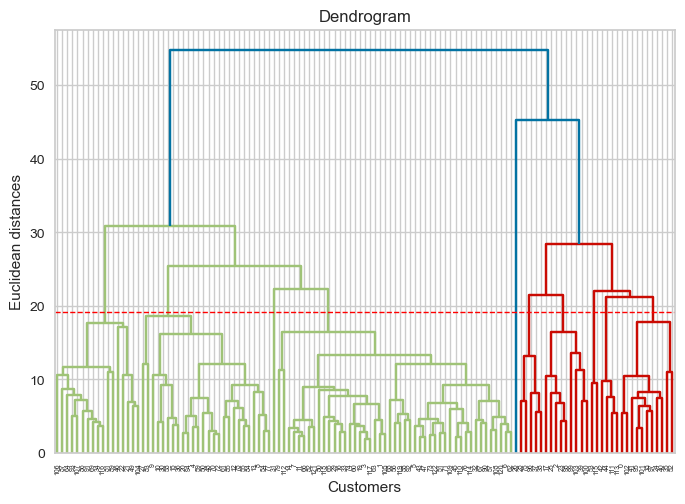

In [177]:
# calculo do dendrograma com método ward
dendrogram = sch.dendrogram(sch.linkage(bgri_cluster[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8','PCA_h_9','PCA_h_10','PCA_h_11',
                                                      'PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10']], method  = 'ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.axhline(19.2, color='red', linestyle='--', linewidth=1)
plt.show()

### 2.4 Clustering

#### 2.4.1 Ward Linkage

In [178]:
# Contiguity matrix Queen
RANDOM_SEED = 123456

wqueen = Queen.from_dataframe(clusters,silence_warnings=True)


In [179]:
# Contiguity matrix Queen (arry like)
df  = pd.DataFrame(*wqueen.full()).astype(int)

arr = df.to_numpy()

arr2d = np.transpose(arr)

In [180]:
# Contiguity matrix Queen row standardization
wqueen.set_transform('R')

In [181]:
# number of clusters suggested by the dendrogram
n_clusters=10

In [182]:
# Agglomerative Clustering, no contiguity matrix, ward linkage
hc = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage ='ward')

In [183]:
y_hc=hc.fit_predict(bgri_cluster)

/Users/andresilvalima/opt/anaconda3/envs/BIC/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead



In [184]:
# write labels in our dataframe
bgri_cluster['Zona_Ward']=y_hc.T

In [185]:
bgri_cluster.head()

,Cluster_new,PER_EDIFICIOS_CLASSICOS_ISOLADOS,PER_EDIFICIOS_CLASSICOS_GEMIN,PER_EDIFICIOS_CLASSICOS_EMBANDA,PER_EDIFICIOS_CLASSICOS_1OU2,PER_EDIFICIOS_CLASSICOS_3OUMAIS,PER_EDIFICIOS_CLASSICOS_OUTROS,PER_EDIFICIOS_EXCLUSIV_RESID,PER_EDIFICIOS_PRINCIPAL_RESID,PER_EDIFICIOS_PRINCIP_NAO_RESID,...,PCA_p_2,PCA_p_3,PCA_p_4,PCA_p_5,PCA_p_6,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10,Zona_Ward
0,1,0.860281,-0.019130,-0.628075,0.430481,-0.395734,-0.222560,0.448140,-0.411354,-0.469013,...,1.997906,-1.764269,1.408636,2.631111,1.318047,-0.449744,-1.098153,0.121210,-0.405767,4
1,2,0.376284,0.466158,-0.007814,0.650434,-0.638207,-0.137035,0.539082,-0.564478,-0.093894,...,-0.487530,0.946791,0.478374,-0.341725,-0.286278,-0.889590,-0.600227,1.142661,0.163015,4
2,3,-1.038268,-1.399519,-0.107695,-1.955240,2.046739,-0.222560,-1.321379,1.487171,-0.469013,...,0.201904,-2.754519,-1.619068,-2.711608,-3.381321,-0.437178,1.163779,0.507817,-0.045294,4
3,4,0.393808,0.620081,-0.217530,0.592161,-0.575165,-0.153769,0.366449,-0.396317,0.021285,...,0.207844,0.381433,-0.308543,1.147040,-0.194879,0.164786,-0.855227,0.092341,-0.182643,4
4,5,0.136968,0.093963,0.208590,0.357598,-0.390959,0.122955,0.450375,-0.488561,0.036138,...,1.156058,-0.807913,0.362343,-0.039733,-0.395395,0.041874,0.357132,0.053136,0.064562,4


In [186]:
# prepare data for merging
bgri_cluster2=bgri_cluster.iloc[:,-22:]

In [187]:
bgri_cluster2

,PCA_h_1,PCA_h_2,PCA_h_3,PCA_h_4,PCA_h_5,PCA_h_6,PCA_h_7,PCA_h_8,PCA_h_9,PCA_h_10,...,PCA_p_2,PCA_p_3,PCA_p_4,PCA_p_5,PCA_p_6,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10,Zona_Ward
0,-1.089350,-0.220396,0.327666,0.486717,0.093667,1.268302,0.401024,-0.282663,0.195141,-0.247332,...,1.997906,-1.764269,1.408636,2.631111,1.318047,-0.449744,-1.098153,0.121210,-0.405767,4
1,-1.908428,0.098360,-0.043268,-0.013403,-0.705910,0.229802,0.116456,-0.343322,-0.256460,0.170142,...,-0.487530,0.946791,0.478374,-0.341725,-0.286278,-0.889590,-0.600227,1.142661,0.163015,4
2,4.071759,-2.631850,-2.454731,-1.402054,0.647511,-1.903904,-0.304025,0.526995,-0.697956,-2.814143,...,0.201904,-2.754519,-1.619068,-2.711608,-3.381321,-0.437178,1.163779,0.507817,-0.045294,4
3,-1.847645,0.076802,0.727929,0.323953,0.126725,0.193189,0.124968,-0.794445,-0.422768,0.306794,...,0.207844,0.381433,-0.308543,1.147040,-0.194879,0.164786,-0.855227,0.092341,-0.182643,4
4,0.058212,0.421190,0.915971,-0.866360,-1.606856,0.028771,0.010300,0.400150,-0.532586,0.542409,...,1.156058,-0.807913,0.362343,-0.039733,-0.395395,0.041874,0.357132,0.053136,0.064562,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
118,-2.877727,0.242216,1.787907,0.584555,0.502176,-0.183520,-0.031039,0.508017,-0.640336,0.529120,...,-1.626173,-0.334981,0.243530,2.088244,2.108476,-0.324395,-1.529277,-1.448628,0.589750,2
119,-2.911972,-0.264244,0.839999,-0.888996,0.285587,0.754296,-0.230786,1.222763,-0.835768,0.617269,...,-3.042850,-0.321075,-0.639644,-0.262681,0.757649,-1.488342,0.755798,2.064676,-1.399998,2
120,-2.446588,0.127408,-1.236297,-0.218184,-0.028937,-1.365125,0.440782,0.061707,-0.897041,-1.120458,...,-2.823751,-2.084291,-0.583886,-0.876972,-1.424504,-0.773717,-0.216325,-0.153793,-2.221170,2
121,-3.928079,-0.400038,-1.431604,1.672633,1.650028,0.217376,-0.870117,-1.143029,-0.181781,-0.163706,...,-0.058719,-1.445921,-2.409242,1.239066,-0.329159,0.325368,-0.143107,-0.608779,-0.891944,2


In [188]:
# prepare data for merging
bgri_cluster3=bgri_cluster.iloc[:,:1]

In [189]:
# prepare data for merging
bgri_cluster3=bgri_cluster3.iloc[:,-1:]

In [190]:
bgri_cluster3

,Cluster_new
0,1
1,2
2,3
3,4
4,5
...,...
118,127
119,128
120,129
121,130


In [191]:
# concatenate dataframes
bgri_cluster=pd.concat([bgri_cluster2,bgri_cluster3],axis=1)

In [192]:
bgri_cluster.head()

,PCA_h_1,PCA_h_2,PCA_h_3,PCA_h_4,PCA_h_5,PCA_h_6,PCA_h_7,PCA_h_8,PCA_h_9,PCA_h_10,...,PCA_p_3,PCA_p_4,PCA_p_5,PCA_p_6,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10,Zona_Ward,Cluster_new
0,-1.089350,-0.220396,0.327666,0.486717,0.093667,1.268302,0.401024,-0.282663,0.195141,-0.247332,...,-1.764269,1.408636,2.631111,1.318047,-0.449744,-1.098153,0.121210,-0.405767,4,1
1,-1.908428,0.098360,-0.043268,-0.013403,-0.705910,0.229802,0.116456,-0.343322,-0.256460,0.170142,...,0.946791,0.478374,-0.341725,-0.286278,-0.889590,-0.600227,1.142661,0.163015,4,2
2,4.071759,-2.631850,-2.454731,-1.402054,0.647511,-1.903904,-0.304025,0.526995,-0.697956,-2.814143,...,-2.754519,-1.619068,-2.711608,-3.381321,-0.437178,1.163779,0.507817,-0.045294,4,3
3,-1.847645,0.076802,0.727929,0.323953,0.126725,0.193189,0.124968,-0.794445,-0.422768,0.306794,...,0.381433,-0.308543,1.147040,-0.194879,0.164786,-0.855227,0.092341,-0.182643,4,4
4,0.058212,0.421190,0.915971,-0.866360,-1.606856,0.028771,0.010300,0.400150,-0.532586,0.542409,...,-0.807913,0.362343,-0.039733,-0.395395,0.041874,0.357132,0.053136,0.064562,4,5


In [193]:
# merge relevant data (resulting from the PCA) with the cluster dataframe
clusters=clusters.merge(bgri_cluster,how='left',on='Cluster_new')

In [194]:
clusters.head()

,Cluster_new,geometry,area,PCA_h_1,PCA_h_2,PCA_h_3,PCA_h_4,PCA_h_5,PCA_h_6,PCA_h_7,...,PCA_p_2,PCA_p_3,PCA_p_4,PCA_p_5,PCA_p_6,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10,Zona_Ward
0,1,"POLYGON ((-43858.268 105485.133, -43926.607 10...",0.036101,-1.089350,-0.220396,0.327666,0.486717,0.093667,1.268302,0.401024,...,1.997906,-1.764269,1.408636,2.631111,1.318047,-0.449744,-1.098153,0.121210,-0.405767,4
1,2,"POLYGON ((-41894.818 101023.152, -41985.704 10...",0.023841,-1.908428,0.098360,-0.043268,-0.013403,-0.705910,0.229802,0.116456,...,-0.487530,0.946791,0.478374,-0.341725,-0.286278,-0.889590,-0.600227,1.142661,0.163015,4
2,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,4.071759,-2.631850,-2.454731,-1.402054,0.647511,-1.903904,-0.304025,...,0.201904,-2.754519,-1.619068,-2.711608,-3.381321,-0.437178,1.163779,0.507817,-0.045294,4
3,4,"POLYGON ((-42925.331 103598.712, -42932.138 10...",0.142291,-1.847645,0.076802,0.727929,0.323953,0.126725,0.193189,0.124968,...,0.207844,0.381433,-0.308543,1.147040,-0.194879,0.164786,-0.855227,0.092341,-0.182643,4
4,5,"POLYGON ((-42665.937 104985.157, -42696.042 10...",0.141979,0.058212,0.421190,0.915971,-0.866360,-1.606856,0.028771,0.010300,...,1.156058,-0.807913,0.362343,-0.039733,-0.395395,0.041874,0.357132,0.053136,0.064562,4


In [195]:
clusters.shape

(123, 25)

In [196]:
# remove the column with the cluster Zona Ward labels
bgri_cluster.drop(['Zona_Ward'],axis=1,inplace=True)

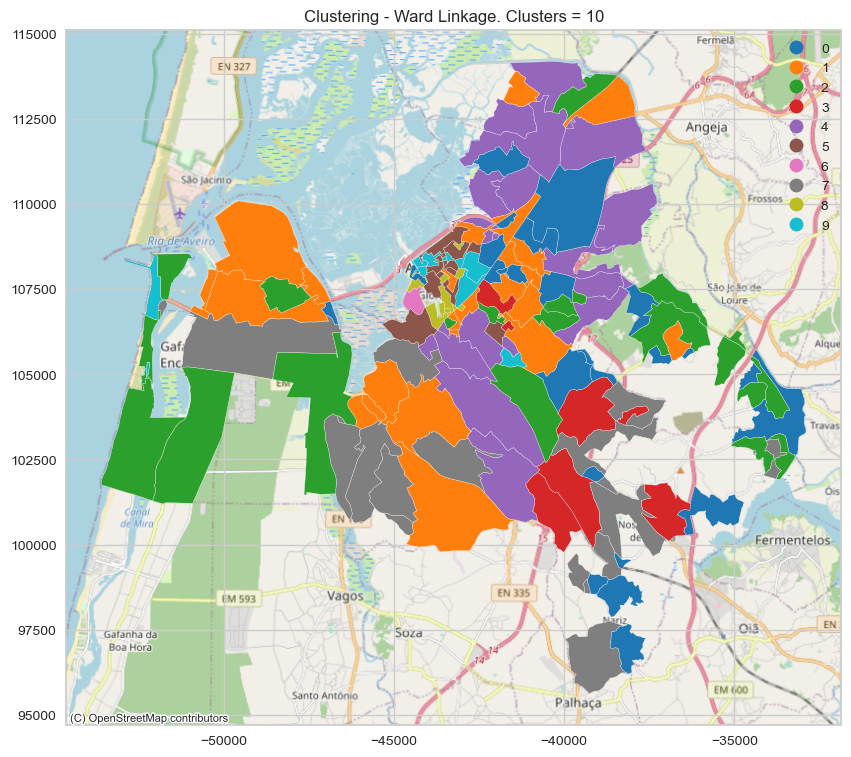

In [197]:
# print the result from the clustering done above
ax=clusters.plot(figsize=(10, 10), column="Zona_Ward", categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab10')
cx.add_basemap(ax,crs=clusters.crs,source=cx.providers.OpenStreetMap.Mapnik)
plt.title('Clustering - Ward Linkage. Clusters = {}'.format(n_clusters))
plt.savefig(path + '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/01_Pictures/Pic_Zona_Ward.png')

#### 2.4.2 Ward Linkage + Queen Contiguity

In [ ]:
# Vamos repetir o processo para o método de Ward matriz de contiguidade

hc2 = AgglomerativeClustering(n_clusters = n_clusters, affinity = 'euclidean', linkage ='ward',connectivity=arr2d)
y_hc2=hc2.fit_predict(bgri_cluster)
clusters['Zona_Ward_Queen']=y_hc2.T

/Users/andresilvalima/opt/anaconda3/envs/BIC/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning:

Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead

/Users/andresilvalima/opt/anaconda3/envs/BIC/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:282: UserWarning:

the number of connected components of the connectivity matrix is 2 > 1. Completing it to avoid stopping the tree early.



In [ ]:
clusters.head()

,Cluster_new,geometry,area,PCA_h_1,PCA_h_2,PCA_h_3,PCA_h_4,PCA_h_5,PCA_h_6,PCA_h_7,...,PCA_p_3,PCA_p_4,PCA_p_5,PCA_p_6,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10,Zona_Ward,Zona_Ward_Queen
0,1,"POLYGON ((-43858.268 105485.133, -43926.607 10...",0.036101,-1.089350,-0.220396,0.327666,0.486717,0.093667,1.268302,0.401024,...,-1.764269,1.408636,2.631111,1.318047,-0.449744,-1.098153,0.121210,-0.405767,4,2
1,2,"POLYGON ((-41894.818 101023.152, -41985.704 10...",0.023841,-1.908428,0.098360,-0.043268,-0.013403,-0.705910,0.229802,0.116456,...,0.946791,0.478374,-0.341725,-0.286278,-0.889590,-0.600227,1.142661,0.163015,4,2
2,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,4.071759,-2.631850,-2.454731,-1.402054,0.647511,-1.903904,-0.304025,...,-2.754519,-1.619068,-2.711608,-3.381321,-0.437178,1.163779,0.507817,-0.045294,4,2
3,4,"POLYGON ((-42925.331 103598.712, -42932.138 10...",0.142291,-1.847645,0.076802,0.727929,0.323953,0.126725,0.193189,0.124968,...,0.381433,-0.308543,1.147040,-0.194879,0.164786,-0.855227,0.092341,-0.182643,4,2
4,5,"POLYGON ((-42665.937 104985.157, -42696.042 10...",0.141979,0.058212,0.421190,0.915971,-0.866360,-1.606856,0.028771,0.010300,...,-0.807913,0.362343,-0.039733,-0.395395,0.041874,0.357132,0.053136,0.064562,4,2


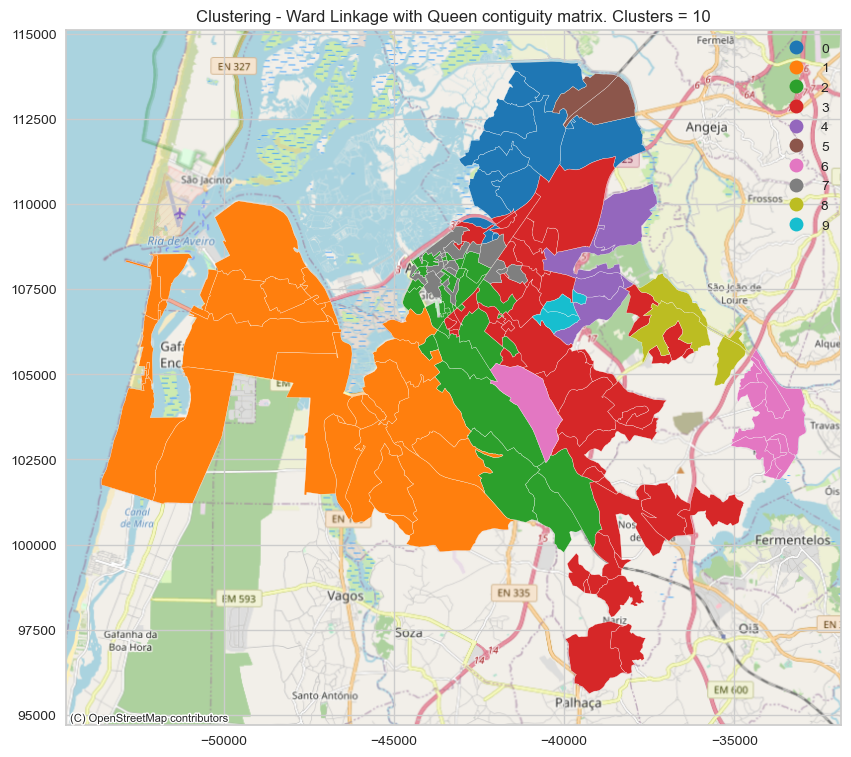

In [ ]:
# print the result from the clustering done above
ax=clusters.plot(figsize=(10, 10), column="Zona_Ward_Queen", categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab10')
cx.add_basemap(ax,crs=clusters.crs,source=cx.providers.OpenStreetMap.Mapnik)
plt.title('Clustering - Ward Linkage with Queen contiguity matrix. Clusters = {}'.format(n_clusters))
plt.savefig(path + '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/01_Pictures/Pic_Zona_Ward_Queen.png')


#### 2.4.3 Max-P Regionalization

https://www.tandfonline.com/doi/full/10.1080/13658816.2020.1759806

https://www.youtube.com/watch?v=HFVKHej1EOc&ab_channel=GeoDaSoftware

É necessário definir a lista de atributos, matriz de pesos espaciais, threshold, threshold_name e o top_n.

In [ ]:
# load data (pickle) casasapo
casasapo = pd.read_pickle(path + "/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/piclo_casasapo.piclo")

# load data (pickle) py
py = pd.read_pickle(path + "/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/piclo_py.piclo")

In [ ]:
# definition of seed
RANDOM_SEED=123456

In [ ]:
casasapo['a']=1
py['a']=1

In [ ]:
# preparation to calculate the number of dwellings per cluster
df_subtotal_cs = pd.DataFrame()
df_subtotal_py = pd.DataFrame()
df_subtotal_cs = casasapo.groupby('Cluster_new', as_index=False)[['a']].agg('sum')
df_subtotal_py = py.groupby('Cluster_new', as_index=False)[['a']].agg('sum')

In [ ]:
# merge with clusters dataframe
clusters=clusters.merge(df_subtotal_cs[['Cluster_new','a']],how='left',on='Cluster_new')
clusters=clusters.merge(df_subtotal_py[['Cluster_new','a']],how='left',on='Cluster_new')

In [ ]:
# drop column 'a'
casasapo.drop(columns=['a'],inplace=True)
py.drop(columns=['a'],inplace=True)

In [ ]:
# rename columns
clusters.rename(columns={'a_x':'tot_cs','a_y':'tot_py'},inplace=True)

In [ ]:
clusters.head()

,Cluster_new,geometry,area,PCA_h_1,PCA_h_2,PCA_h_3,PCA_h_4,PCA_h_5,PCA_h_6,PCA_h_7,...,PCA_p_5,PCA_p_6,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10,Zona_Ward,Zona_Ward_Queen,tot_cs,tot_py
0,1,"POLYGON ((-43858.268 105485.133, -43926.607 10...",0.036101,-1.089350,-0.220396,0.327666,0.486717,0.093667,1.268302,0.401024,...,2.631111,1.318047,-0.449744,-1.098153,0.121210,-0.405767,4,2,154.0,NaN
1,2,"POLYGON ((-41894.818 101023.152, -41985.704 10...",0.023841,-1.908428,0.098360,-0.043268,-0.013403,-0.705910,0.229802,0.116456,...,-0.341725,-0.286278,-0.889590,-0.600227,1.142661,0.163015,4,2,119.0,6.0
2,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,4.071759,-2.631850,-2.454731,-1.402054,0.647511,-1.903904,-0.304025,...,-2.711608,-3.381321,-0.437178,1.163779,0.507817,-0.045294,4,2,67.0,4.0
3,4,"POLYGON ((-42925.331 103598.712, -42932.138 10...",0.142291,-1.847645,0.076802,0.727929,0.323953,0.126725,0.193189,0.124968,...,1.147040,-0.194879,0.164786,-0.855227,0.092341,-0.182643,4,2,118.0,32.0
4,5,"POLYGON ((-42665.937 104985.157, -42696.042 10...",0.141979,0.058212,0.421190,0.915971,-0.866360,-1.606856,0.028771,0.010300,...,-0.039733,-0.395395,0.041874,0.357132,0.053136,0.064562,4,2,146.0,34.0


In [ ]:
clusters[['tot_cs','tot_py']].describe()

,tot_cs,tot_py
count,88.000000,105.000000
mean,81.409091,16.914286
std,130.798400,25.450221
min,1.000000,1.000000
25%,4.750000,3.000000
50%,33.500000,7.000000
75%,96.000000,20.000000
max,770.000000,185.000000


In [ ]:
# define the minimum number of dwellings per cluster, pre and post intervention (casasapo and py)
clusters['tot_min']=clusters[['tot_cs','tot_py']].min(axis=1)

In [ ]:
attrs_name = list(clusters[['PCA_h_1', 'PCA_h_2', 'PCA_h_3', 'PCA_h_4','PCA_h_5', 'PCA_h_6', 'PCA_h_7','PCA_h_8','PCA_h_9','PCA_h_10','PCA_h_11','PCA_p_1', 'PCA_p_2', 'PCA_p_3','PCA_p_4', 'PCA_p_5', 'PCA_p_6', 'PCA_p_7', 'PCA_p_8', 'PCA_p_9', 'PCA_p_10']])

In [ ]:
# minimum number of dwellings per cluster
threshold = 850

In [ ]:
top_n = 3

In [ ]:
# criteria for the alghoritm - number of dwellings per cluster
threshold_name='tot_min'

In [ ]:
# model with MaxP
np.random.seed(RANDOM_SEED)
model_maxp = MaxP(clusters, wqueen, attrs_name, threshold_name, threshold, top_n)
model_maxp.solve()

In [ ]:
clusters["Zona_Maxp"] = model_maxp.labels_

In [ ]:
clusters[["Zona_Maxp"]].groupby(by="Zona_Maxp").count()

""
Zona_Maxp
1
2
3
4
5
6
7


In [ ]:
a=model_maxp.p
a

7

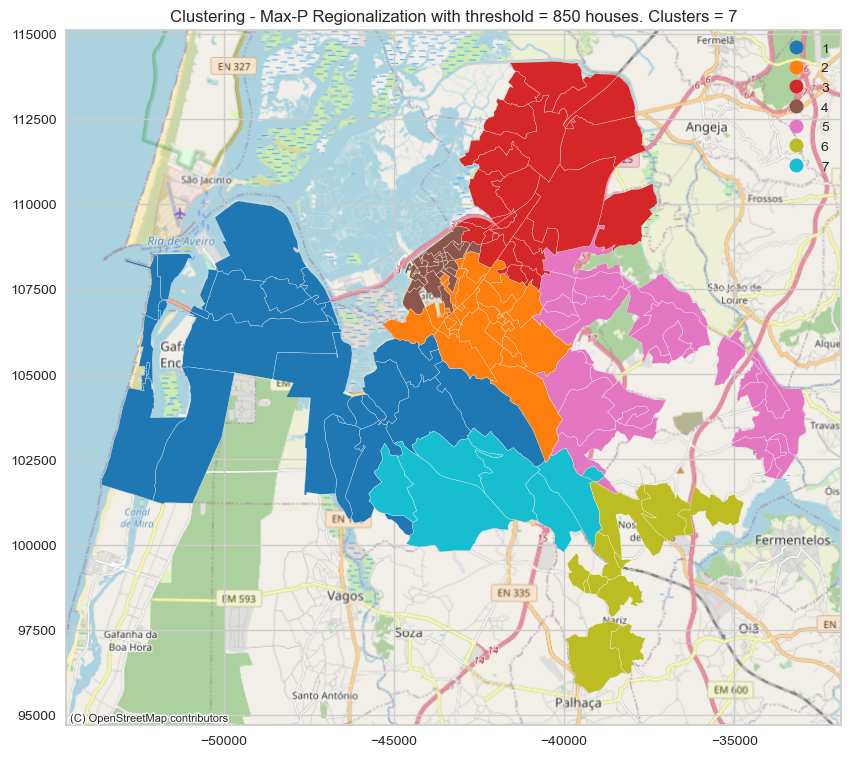

In [ ]:
# result from the Max-P Regionalization
ax=clusters.plot(figsize=(10, 10), column="Zona_Maxp", categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab10')
cx.add_basemap(ax,crs=clusters.crs,source=cx.providers.OpenStreetMap.Mapnik)
plt.title('Clustering - Max-P Regionalization with threshold = %s houses. Clusters = %s' % (threshold, a))
plt.savefig(path + '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/01_Pictures/Pic_Zona_Maxp.png')


In [ ]:
clusters.head()

,Cluster_new,geometry,area,PCA_h_1,PCA_h_2,PCA_h_3,PCA_h_4,PCA_h_5,PCA_h_6,PCA_h_7,...,PCA_p_7,PCA_p_8,PCA_p_9,PCA_p_10,Zona_Ward,Zona_Ward_Queen,tot_cs,tot_py,tot_min,Zona_Maxp
0,1,"POLYGON ((-43858.268 105485.133, -43926.607 10...",0.036101,-1.089350,-0.220396,0.327666,0.486717,0.093667,1.268302,0.401024,...,-0.449744,-1.098153,0.121210,-0.405767,4,2,154.0,NaN,154.0,1
1,2,"POLYGON ((-41894.818 101023.152, -41985.704 10...",0.023841,-1.908428,0.098360,-0.043268,-0.013403,-0.705910,0.229802,0.116456,...,-0.889590,-0.600227,1.142661,0.163015,4,2,119.0,6.0,6.0,7
2,3,"POLYGON ((-43381.069 106148.686, -43381.861 10...",0.024286,4.071759,-2.631850,-2.454731,-1.402054,0.647511,-1.903904,-0.304025,...,-0.437178,1.163779,0.507817,-0.045294,4,2,67.0,4.0,4.0,2
3,4,"POLYGON ((-42925.331 103598.712, -42932.138 10...",0.142291,-1.847645,0.076802,0.727929,0.323953,0.126725,0.193189,0.124968,...,0.164786,-0.855227,0.092341,-0.182643,4,2,118.0,32.0,32.0,1
4,5,"POLYGON ((-42665.937 104985.157, -42696.042 10...",0.141979,0.058212,0.421190,0.915971,-0.866360,-1.606856,0.028771,0.010300,...,0.041874,0.357132,0.053136,0.064562,4,2,146.0,34.0,34.0,2


#### 2.4.4 SKATER (Spatial ’K’luster Analysis by Tree Edge Removal)

https://www.tandfonline.com/doi/full/10.1080/13658810600665111

https://pysal.org/spopt/notebooks/skater.html

https://pysal.org/spopt/generated/spopt.region.Skater.html#spopt.region.Skater

https://www.dshkol.com/post/spatially-constrained-clustering-and-regionalization/

In [ ]:
# minimum number of clusters
n_clusters = 10

In [ ]:
# minimum number of zones per cluster
floor = 5

In [ ]:
trace = False

In [ ]:
islands = "increase"

In [ ]:
# standard definition for the spannig tree algorithm
spanning_forest_kwds = dict(dissimilarity=skm.manhattan_distances,affinity=None,reduction=np.sum,center=np.mean,verbose=1)


In [ ]:
# model using the skater algorithm
model_skater = spopt.region.Skater(clusters,wqueen,attrs_name,n_clusters=n_clusters,floor=floor,trace=trace,islands=islands,spanning_forest_kwds=spanning_forest_kwds)
model_skater.solve()

/Users/andresilvalima/opt/anaconda3/envs/BIC/lib/python3.10/site-packages/spopt/region/skater.py:537: OptimizeWarning:

By default, the graph is disconnected! Increasing `n_clusters` from 10 to 12 in order to account for islands.



finding cut...:   0%|          | 0/121 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/120 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/119 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/118 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/117 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/116 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/115 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/114 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/113 [00:00<?, ?it/s]

finding cut...:   0%|          | 0/112 [00:00<?, ?it/s]

In [ ]:
# write skater cluster info
clusters["Zona_SKATER"] = model_skater.labels_

In [ ]:
# resulting number of clusters, for the graph title
temp=len(clusters["Zona_SKATER"].unique())
temp

12

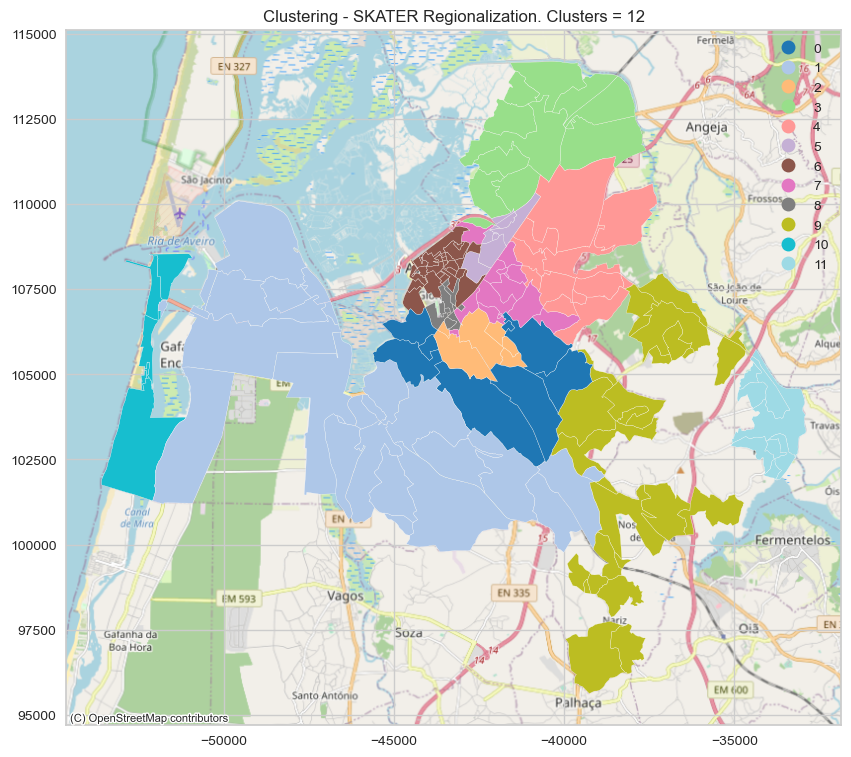

In [ ]:
# result of the SKATER Regionalization
ax=clusters.plot(figsize=(10, 10), column="Zona_SKATER", categorical=True, edgecolor="w", legend=True, linewidth=0.2,cmap='tab20')
cx.add_basemap(ax,crs=clusters.crs,source=cx.providers.OpenStreetMap.Mapnik)
plt.title('Clustering - SKATER Regionalization. Clusters = {}'.format(temp))
plt.savefig(path + '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/01_Pictures/Pic_Zona_SKATER.png')

## 2.5 Export Data to Pickle Files

In [ ]:
# save data (pickle) bgri
bgri_cluster.to_pickle(path+ '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/piclo_bgri_2.piclo')

In [ ]:
# save data (pickle) clusters
clusters.to_pickle(path+ '/POAT/Andre_Lima/05_OK_Notebooks_new_clusters/02_Pickles/piclo_clusters_2.piclo')